In [323]:
import greedy_builder
import pickle
import matplotlib.pyplot as plt
import re
import numpy as np

def read_cpp_res(domain):
    tokens = [bytes.fromhex(t.strip()) for t in open(f'cpp_outputs/{domain}/tokens.txt','r').read().strip().split('\n')]
    merges_per_turn = [int(x) for x in open(f'cpp_outputs/{domain}/merges.txt','r').read().strip().split('\n')]
    total = 0
    totals = []
    for m in merges_per_turn:
        total += m
        totals.append(total)
    return tokens, merges_per_turn, totals

def read_hf_bl_bpe(domain):
    return [re.sub('Äł', 'Ġ', re.sub(' ', '', t)) 
            for t in open(f"python_outputs/hf_bl_bpe/{domain}_model/merges.txt",'r')
            .read().strip().split('\n')][1:]

def score_turns(rank, counts):
    test = greedy_builder.build(rank)
    turns = [0] * len(rank)
    words = list(counts.keys())
    turn_scores = test.batch_score_merges_per_turn(words)
    for w, ts in zip(words, turn_scores):
        for t,s in ts:
            turns[t] += s*counts[w]
    aggregate = [0]
    for turn in turns:
        aggregate.append(turn+aggregate[-1])
    aggregate = np.array(aggregate[1:])
    total = sum([len(v.encode('utf-8'))*c for v,c in counts.items()])
    word_per_token = (total - aggregate) / sum(counts.values())
    
    return turns, aggregate, word_per_token

In [325]:
greed_merges = {}
greed_aggr = {}
greed_tpw = {}
bpe_merges = {}
bpe_aggr = {}
bpe_tpw = {}
hfbpe_merges = {}
hfbpe_aggr = {}
hfbpe_tpw = {}

In [324]:
for domain in ['un', 'arxiv']:
    counts = pickle.load(open(f'python_inputs/{domain}_counts.pkl', 'rb'))
    tokens, merges_per_turn, totals = read_cpp_res(domain)
    greed_merges[domain], greed_aggr[domain], greed_tpw[domain] = score_turns(tokens[:5000],counts)
    tokens = [b''.join(t) for t in pickle.load(open(f"python_outputs/slow_bpe/{domain}_bpe.pkl",'rb'))['rules']]
    bpe_merges[domain], bpe_aggr[domain], bpe_tpw[domain] = score_turns(tokens[:5000],counts)
    tokens = read_hf_bl_bpe(domain)
    hfbpe_merges[domain], hfbpe_aggr[domain], hfbpe_tpw[domain] = score_turns(tokens[:5000],counts)
    print(domain)
    
for domain in ['wiki', 'pubmed']:
    counts = pickle.load(open(f'python_inputs/{domain}_counts.pkl', 'rb'))
    tokens, merges_per_turn, totals = read_cpp_res(domain)
    greed_merges[domain], greed_aggr[domain], greed_tpw[domain] = score_turns(tokens[:10000],counts)
    tokens = [b''.join(t) for t in pickle.load(open(f"python_outputs/slow_bpe/{domain}_bpe.pkl",'rb'))['rules']]
    bpe_merges[domain], bpe_aggr[domain], bpe_tpw[domain] = score_turns(tokens[:10000],counts)
    print(domain)

un
arxiv
wiki
pubmed


In [78]:
import os
for domain in ['un','arxiv']:
    os.makedirs(f'processed_results/{domain}',exist_ok=True)    
    pickle.dump(greed_merges[domain], open(f'processed_results/{domain}/greed_merges.pkl','wb'))
    pickle.dump(greed_aggr[domain], open(f'processed_results/{domain}/greed_aggr.pkl','wb'))
    pickle.dump(greed_tpw[domain], open(f'processed_results/{domain}/greed_tpw.pkl','wb'))
    pickle.dump(bpe_merges[domain], open(f'processed_results/{domain}/bpe_merges.pkl','wb'))
    pickle.dump(bpe_aggr[domain], open(f'processed_results/{domain}/bpe_aggr.pkl','wb'))
    pickle.dump(bpe_tpw[domain], open(f'processed_results/{domain}/bpe_tpw.pkl','wb'))
    pickle.dump(hfbpe_merges[domain], open(f'processed_results/{domain}/hfbpe_merges.pkl','wb'))
    pickle.dump(hfbpe_aggr[domain], open(f'processed_results/{domain}/hfbpe_agr.pkl','wb'))
    pickle.dump(hfbpe_tpw[domain], open(f'processed_results/{domain}/hfbpe_merges.pkl','wb'))


for domain in ['wiki','pubmed']:
    os.makedirs(f'processed_results/{domain}',exist_ok=True)    
    pickle.dump(greed_merges[domain], open(f'processed_results/{domain}/greed_merges.pkl','wb'))
    pickle.dump(greed_aggr[domain], open(f'processed_results/{domain}/greed_aggr.pkl','wb'))
    pickle.dump(greed_tpw[domain], open(f'processed_results/{domain}/greed_tpw.pkl','wb'))
    pickle.dump(bpe_merges[domain], open(f'processed_results/{domain}/bpe_merges.pkl','wb'))
    pickle.dump(bpe_aggr[domain], open(f'processed_results/{domain}/bpe_aggr.pkl','wb'))
    pickle.dump(bpe_tpw[domain], open(f'processed_results/{domain}/bpe_tpw.pkl','wb'))

In [327]:
import os
for domain in ['un','arxiv']:
    greed_merges[domain]  = pickle.load(open(f'processed_results/{domain}/greed_merges.pkl','rb'))
    greed_aggr[domain] = pickle.load(open(f'processed_results/{domain}/greed_aggr.pkl','rb'))
    greed_tpw[domain] = pickle.load(open(f'processed_results/{domain}/greed_tpw.pkl','rb'))
    bpe_merges[domain] = pickle.load(open(f'processed_results/{domain}/bpe_merges.pkl','rb'))
    bpe_aggr[domain] = pickle.load(open(f'processed_results/{domain}/bpe_aggr.pkl','rb'))
    bpe_tpw[domain] = pickle.load(open(f'processed_results/{domain}/bpe_tpw.pkl','rb'))
    hfbpe_merges[domain] = pickle.load(open(f'processed_results/{domain}/hfbpe_merges.pkl','rb'))
    hfbpe_aggr[domain] = pickle.load(open(f'processed_results/{domain}/hfbpe_agr.pkl','rb'))
    hfbpe_tpw[domain] = pickle.load(open(f'processed_results/{domain}/hfbpe_merges.pkl','rb'))
    

for domain in ['wiki','pubmed']:
    greed_merges[domain]  = pickle.load(open(f'processed_results/{domain}/greed_merges.pkl','rb'))
    greed_aggr[domain] = pickle.load(open(f'processed_results/{domain}/greed_aggr.pkl','rb'))
    greed_tpw[domain] = pickle.load(open(f'processed_results/{domain}/greed_tpw.pkl','rb'))
    bpe_merges[domain] = pickle.load(open(f'processed_results/{domain}/bpe_merges.pkl','rb'))
    bpe_aggr[domain] = pickle.load(open(f'processed_results/{domain}/bpe_aggr.pkl','rb'))
    bpe_tpw[domain] = pickle.load(open(f'processed_results/{domain}/bpe_tpw.pkl','rb'))

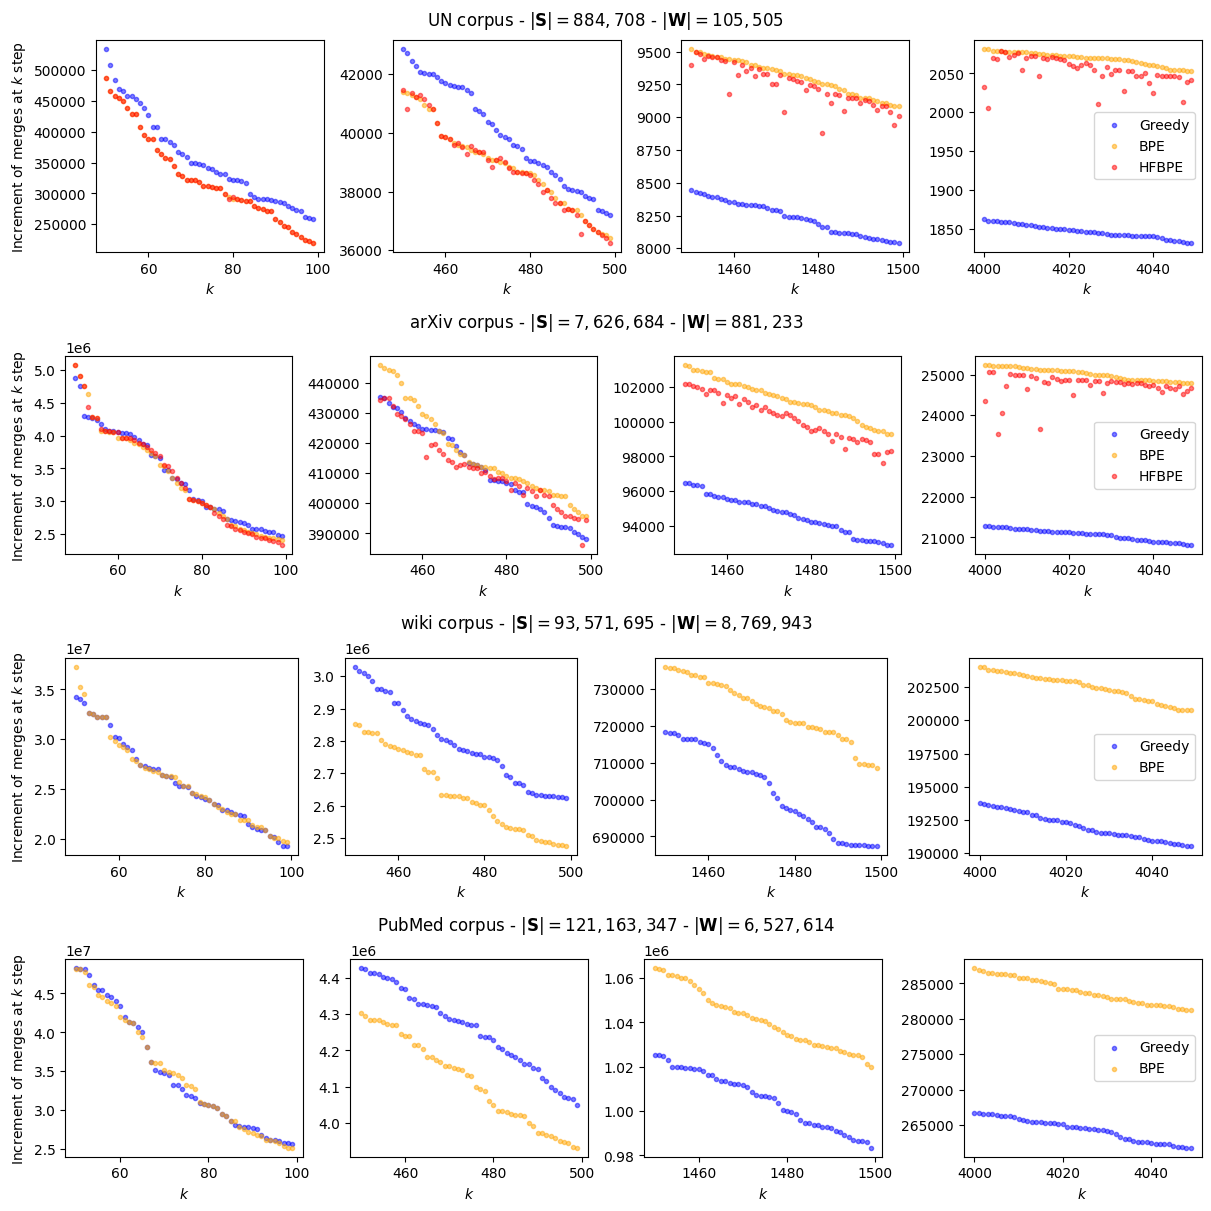

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(12,12))
# fig.suptitle('Figure title')            # set global suptitle if desired
suptitles = [r'UN corpus - $|\mathbf{S}|=884,708$ - $|\mathbf{W}|=105,505$',
            r'arXiv corpus - $|\mathbf{S}|=7,626,684$ - $|\mathbf{W}|=881,233$',
            r'wiki corpus - $|\mathbf{S}|=93,571,695$ - $|\mathbf{W}|=8,769,943$',
            r'PubMed corpus - $|\mathbf{S}|=121,163,347$ - $|\mathbf{W}|=6,527,614$']
subfigs = fig.subfigures(4, 1) 
for d, domain in enumerate(['un','arxiv', 'wiki', 'pubmed']):
    
    axs = subfigs[d].subplots(1, 4)  
    for idx, scope in enumerate([(50,100), (450,500), (1450,1500), (4000,4050)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_merges[domain]))[i:j], greed_merges[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_merges[domain]))[i:j], bpe_merges[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        if domain in hfbpe_merges:
            axs[idx].scatter(range(len(hfbpe_merges[domain]))[i:j], hfbpe_merges[domain][i:j], color='red', marker='.', alpha=.5, label='HFBPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Increment of merges at $k$ step")
    subfigs[d].suptitle(suptitles[d])

plt.show()
# HF BPE have byte fallback

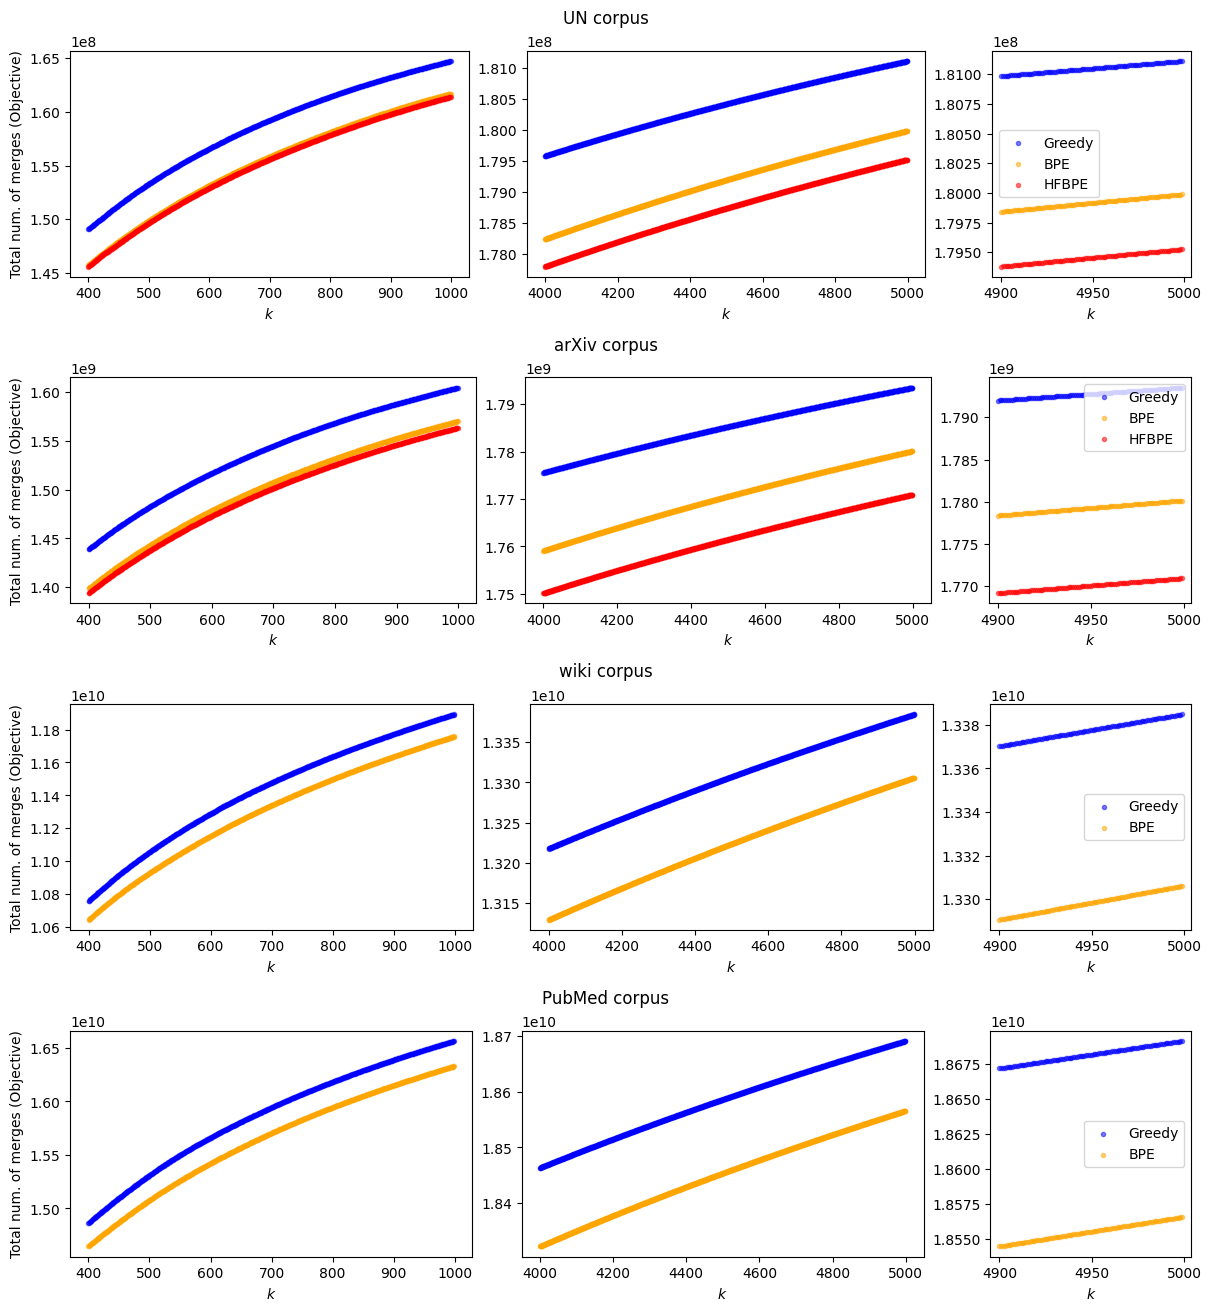

In [38]:
fig = plt.figure(constrained_layout=True, figsize=(12,13))

suptitles = [f'UN corpus',
            f'arXiv corpus',
            f'wiki corpus',
            f'PubMed corpus']
subfigs = fig.subfigures(4, 1) 
for d, domain in enumerate(['un','arxiv','wiki','pubmed']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(400,1000), (4000,5000), (4900,5000)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_aggr[domain]))[i:j], greed_aggr[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_aggr[domain]))[i:j], bpe_aggr[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        if domain in hfbpe_aggr:
            axs[idx].scatter(range(len(hfbpe_aggr[domain]))[i:j], hfbpe_aggr[domain][i:j], color='red', marker='.', alpha=.5, label='HFBPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Total num. of merges (Objective)")
    subfigs[d].suptitle(suptitles[d])
plt.show()

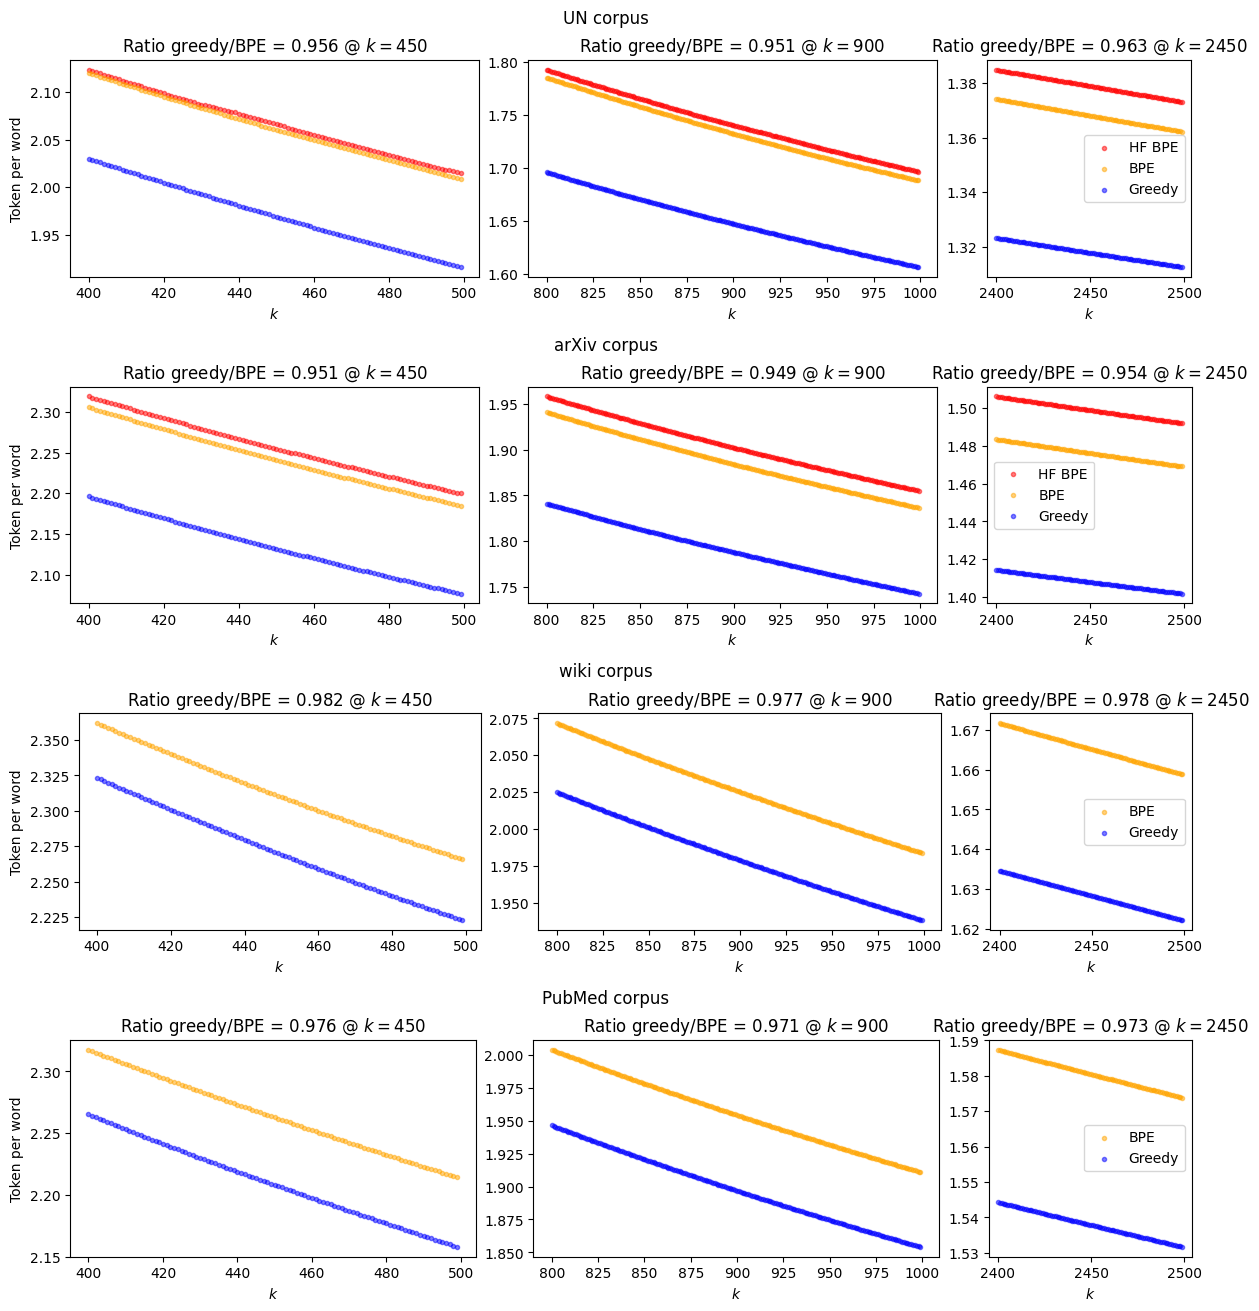

In [79]:
fig = plt.figure(constrained_layout=True, figsize=(12,13))

suptitles = [f'UN corpus',
            f'arXiv corpus',
             f'wiki corpus',
            f'PubMed corpus']
subfigs = fig.subfigures(4, 1) 
for d, domain in enumerate(['un','arxiv','wiki','pubmed']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(400,500), (800,1000), (2400,2500)]):
        i,j = scope
        if domain in hfbpe_tpw:
            axs[idx].scatter(range(len(hfbpe_tpw[domain]))[i:j], hfbpe_tpw[domain][i:j], color='red', marker='.', alpha=.5, label='HF BPE')
        axs[idx].scatter(range(len(bpe_tpw[domain]))[i:j], bpe_tpw[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].scatter(range(len(greed_tpw[domain]))[i:j], greed_tpw[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].set_xlabel("$k$")
        inspect = int((i+j)/2)
        if inspect < len(greed_tpw[domain]):
            axs[idx].set_title(f"Ratio greedy/BPE = \
{greed_tpw[domain][inspect]/bpe_tpw[domain][inspect]:.3f} \
@ $k={inspect}$")
    axs[-1].legend()
    axs[0].set_ylabel("Token per word")
    subfigs[d].suptitle(suptitles[d])
plt.show()

In [328]:
def bold(s):
    return '\033[1m' + s + '\033[0m'

def ul(s):
    return '\033[4m' + s + '\033[0m'

def b_cond(s , target_ratio):
    if target_ratio == 15 or target_ratio == 25:
        return bold(s)
    return s

In [84]:
target_ratios = [13+(x*2) for x in range(8)]
greed_ratio2k = {}
bpe_ratio2k = {}
greed_k2ratio = {}
bpe_k2ratio = {}

for domain in ['un', 'arxiv', 'wiki', 'pubmed']:
    greed_ratio2k[domain] = {}
    greed_k2ratio[domain] = {}
    bpe_ratio2k[domain] = {}
    bpe_k2ratio[domain] = {}
    for target_ratio in target_ratios:
        tr = target_ratio/10
        best_diff = 9999
        for k, token_per_word in enumerate(greed_tpw[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                greed_ratio2k[domain][target_ratio] = k
                greed_k2ratio[domain][k] = token_per_word
                
                bpe_k2ratio[domain][k] = bpe_tpw[domain][k]
                bpe_ratio2k[domain][bpe_tpw[domain][k]] = k
        
        best_diff = 9999
        for k, token_per_word in enumerate(bpe_tpw[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                bpe_ratio2k[domain][target_ratio] = k
                bpe_k2ratio[domain][k] = token_per_word
                
                greed_k2ratio[domain][k] = greed_tpw[domain][k]
                greed_ratio2k[domain][greed_tpw[domain][k]] = k


for domain in ['un', 'arxiv', 'wiki', 'pubmed']:
    print(ul(bold(domain)))
    print("token/w tar\t", "\t".join([ul(b_cond(f"{tr/10:.1f}",tr)) for tr in target_ratios]))
    print("Greedy $k$\t", "\t".join([b_cond(f"{greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("BPE t/w   \t", "\t".join([b_cond(f"{bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    
    print("Greedy/BPE\t", "\t".join([b_cond(f"{tr/10/bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    print("BPE tar@k \t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("tar@k diff\t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("% > greed \t", "\t".join([b_cond(f"{(bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr])/greed_ratio2k[domain][tr]*100:.1f}%",tr) for tr in target_ratios]))
    
    print()


un
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 2625	1340	793	516	350	242	175	129
BPE t/w   	 1.348	1.572	1.789	1.992	2.189	2.392	2.589	2.780
Greedy/BPE	 0.964	0.954	0.950	0.954	0.959	0.962	0.966	0.971
BPE tar@k 	 3131	1629	971	625	416	285	202	147
tar@k diff	 506	289	178	109	66	43	27	18
% > greed 	 19.3%	21.6%	22.4%	21.1%	18.9%	17.8%	15.4%	14.0%

arxiv
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 3609	1857	1104	708	478	333	237	171
BPE t/w   	 1.350	1.580	1.792	2.002	2.208	2.407	2.593	2.773
Greedy/BPE	 0.963	0.950	0.949	0.949	0.951	0.956	0.964	0.974
BPE tar@k 	 4309	2293	1373	871	585	404	282	195
tar@k diff	 700	436	269	163	107	71	45	24
% > greed 	 19.4%	23.5%	24.4%	23.0%	22.4%	21.3%	19.0%	14.0%

wiki
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 9118	3836	1952	1105	665	421	277	188
BPE t/w   	 1.319	1.531	1.739	1.945	2.146	2.339	2.532	2.725
Greedy/BPE	 0.986	0.980	0.977	0.977	0.978	0.983	0.988	0.991
BPE tar@k 	 9999	4287	2197	1246	746	460	296	197
tar@k 

In [331]:
bpe_tokens = {}
greed_tokens = {}
common_tokens = {}
bpe_ex = {}
greed_ex = {}
bpe_rank = {}
greed_rank = {}
print('\t', ul('common'), ul('bpe_ex'), ul('greedy_ex'))
start = 0
for domain, stop in [('un',5000),('arxiv',5000),('wiki',10000),('pubmed',10000)]:
    tokens , _, __ = read_cpp_res(domain)
    greed_tokens[domain] = tokens [start:stop]
    bpe_tokens[domain] = [b''.join(t) for t in pickle.load(open(f"python_outputs/slow_bpe/{domain}_bpe.pkl",'rb'))['rules']][start:stop]
    
    bpe_rank[domain] = {token:i for i,token in enumerate(bpe_tokens[domain])}
    greed_rank[domain] = {token:i for i,token in enumerate(greed_tokens[domain])}
    common_tokens[domain] = set(bpe_tokens[domain]).intersection(greed_tokens[domain])
    bpe_ex[domain] = set(bpe_rank[domain].keys()).difference(common_tokens[domain])
    greed_ex[domain] = set(greed_rank[domain].keys()).difference(common_tokens[domain])
    print(ul(bold(domain))+'\t', len(common_tokens[domain]), '\t', len(bpe_ex[domain]), '\t', len(greed_ex[domain]))

	 common bpe_ex greedy_ex
un	 3667 	 1333 	 1333
arxiv	 3725 	 1275 	 1275
wiki	 8323 	 1677 	 1677
pubmed	 7982 	 2018 	 2018


In [332]:
common_count   = {}
bpe_ex_count   = {}
greed_ex_count = {}
bpe_visited    = {}
greed_visited  = {}

start = 0

for domain, stop in [('un',5000),('arxiv',5000),('wiki',10000),('pubmed',10000)]:
    
    common_count[domain]   = [0]
    bpe_ex_count[domain]   = [0]
    greed_ex_count[domain] = [0]
    bpe_visited[domain]    = set()
    greed_visited[domain]  = set()
    
    for bpe_token, greed_token in zip(bpe_tokens[domain][start:stop], greed_tokens[domain][start:stop]):
        
        bpe_ex_count[domain].append(bpe_ex_count[domain][-1])
        greed_ex_count[domain].append(greed_ex_count[domain][-1])
        common_count[domain].append(common_count[domain][-1])
        
        if bpe_token == greed_token:
            common_count[domain][-1] += 1
            
        if bpe_token in greed_visited[domain]:
            greed_ex_count[domain][-1] -= 1
            common_count[domain][-1] += 1
        else:
            bpe_ex_count[domain][-1] += 1

        if greed_token in bpe_visited[domain]:
            bpe_ex_count[domain][-1] -= 1
            common_count[domain][-1] += 1
        else:
            greed_ex_count[domain][-1] += 1
        
        bpe_visited[domain].add(bpe_token)
        greed_visited[domain].add(greed_token)

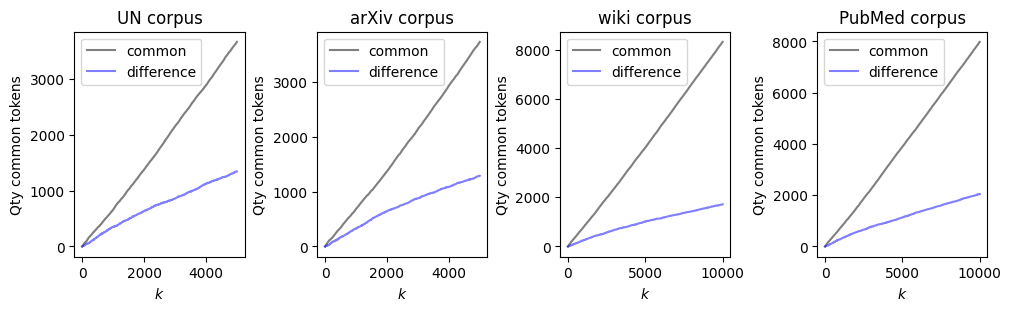

In [333]:
fig, axs = plt.subplots(1,4, figsize=(10,3), layout='constrained')
for idx, domain in enumerate(['un', 'arxiv', 'wiki', 'pubmed']):
    axs[idx].plot(common_count[domain], color='k', alpha=.5, label='common')
    axs[idx].plot(greed_ex_count[domain], color="blue", alpha=.5, label='difference')
#     plt.plot(bpe_ex_count[domain], color="orange", alpha=.5, label='bpe')
    axs[idx].set_title(suptitles[idx])
    axs[idx].legend()
    axs[idx].set_ylabel('Qty common tokens')
    axs[idx].set_xlabel('$k$')
plt.show()

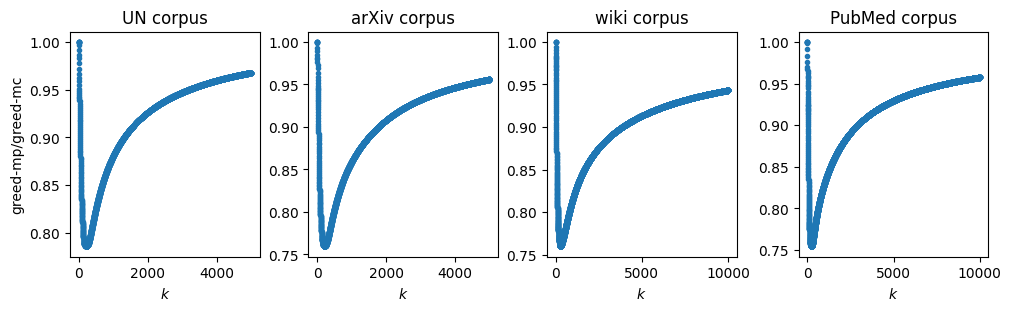

In [341]:
import numpy as np
import matplotlib.pyplot as plt

def read_cpp_res(domain):
    tokens = [bytes.fromhex(t.strip()) for t in open(f'cpp_outputs/{domain}/tokens.txt','r').read().strip().split('\n')]
    merges_per_turn = [int(x) for x in open(f'cpp_outputs/{domain}/merges.txt','r').read().strip().split('\n')]
    total = 0
    totals = []
    for m in merges_per_turn:
        total += m
        totals.append(total)
    return tokens, merges_per_turn, totals

def read_cpp_max_cover(domain):
    ranks = [bytes.fromhex(t.strip()) for t in open(f'cpp_outputs/{domain}/tokens.txt','r').read().strip().split('\n')]
    merges_per_turn = [int(x) for x in open(f'cpp_outputs/{domain}/max_cover_count.txt','r').read().split()]
    total = 0
    totals = []
    for m in merges_per_turn:
        total += m
        totals.append(total)
    return ranks, merges_per_turn, totals


suptitles = [f'UN corpus',
            f'arXiv corpus',
             f'wiki corpus',
            f'PubMed corpus']
fig, axs = plt.subplots(1,4, figsize=(10,3), layout='constrained')
for idx, domain in enumerate(['un', 'arxiv', 'wiki', 'pubmed']):
    _, __, mp_totals = read_cpp_res(domain)
    _, __, mc_totals = read_cpp_max_cover(domain)
    totals = np.array(mp_totals)/np.array(mc_totals)
    axs[idx].scatter(range(len(totals)), totals, marker='.')
    axs[idx].set_title(suptitles[idx])
    if idx == 0:
        axs[idx].set_ylabel('greed-mp/greed-mc')
    axs[idx].set_xlabel('$k$')
plt.show()

In [337]:
for domain in ['un', 'arxiv', 'wiki']:
    counts = pickle.load(open(f'python_inputs/{domain}_counts.pkl', 'rb'))
    total = 0
    for k,c in counts.items():
        total += (len(k.encode('utf-8'))-1) * c
    mc = sum([int(x) for x in open(f"cpp_outputs/{domain}/max_cover_count.txt").read().strip().split('\n')])
    mp = sum([int(x) for x in open(f"cpp_outputs/{domain}/merges.txt").read().strip().split('\n')])
    print(total, mc, mp)
# un and arxiv fully covered by 5k steps, while wiki is not fully covered at 10k steps

187147903 187147903 181111127
1876232596 1876232596 1793499648
14659210396 14659000682 13825591837


In [357]:
tpw = {}
for domain in ['wiki-chinese', 'wiki-japanese', 'wiki-korean']:
    tpw[domain] = {}
    counts = pickle.load(open(f'python_inputs/{domain}_counts.pkl', 'rb'))
    for tk in ['wiki-chinese', 'wiki-japanese', 'wiki-korean', 'wiki-cjk']:
        tokens, merges_per_turn, totals = read_cpp_res(tk)
        _, __, tpw[domain][tk] = score_turns(tokens[:10000],counts)
        print(domain, tk)
        

wiki-chinese wiki-chinese
wiki-chinese wiki-japanese
wiki-chinese wiki-korean
wiki-chinese wiki-cjk
wiki-japanese wiki-chinese
wiki-japanese wiki-japanese
wiki-japanese wiki-korean
wiki-japanese wiki-cjk
wiki-korean wiki-chinese
wiki-korean wiki-japanese
wiki-korean wiki-korean
wiki-korean wiki-cjk


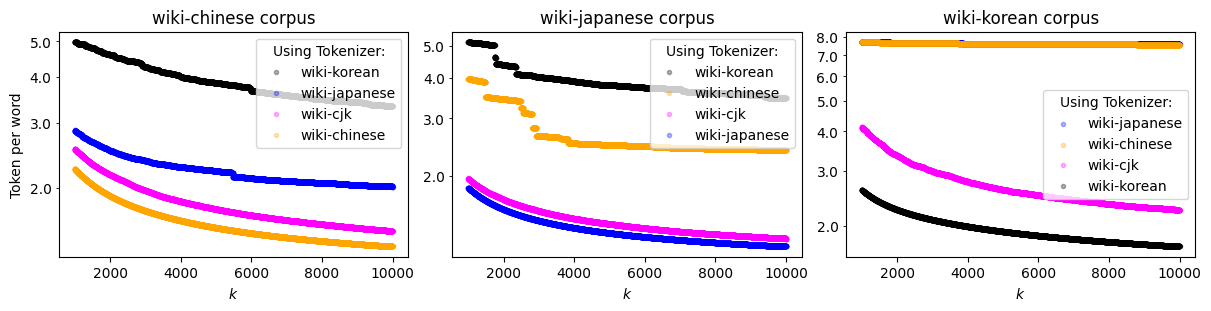

In [363]:
from matplotlib import ticker

fig, axs = plt.subplots(1,3, constrained_layout=True, figsize=(12,3))
colors = ['orange','blue','black','magenta']
for idx, domain in enumerate([f'wiki-chinese',f'wiki-japanese',f'wiki-korean',]):
    i,j = scope = 1000,10000
    order = sorted([(tk,colors[t],tpw[domain][tk][-1]) for t,tk in enumerate(['wiki-chinese', 'wiki-japanese', 'wiki-korean', 'wiki-cjk'])],
                  key = lambda x:x[-1], reverse=True)
    axs[idx].set_yscale("log")
    axs[idx].yaxis.set_minor_formatter(ticker.ScalarFormatter())
    for tk, color, _ in order:
        axs[idx].scatter(range(len(tpw[domain][tk]))[i:j], tpw[domain][tk][i:j], color=color, marker='.', alpha=.3, label=f'{tk}')
    
    axs[idx].set_xlabel("$k$")
    inspect = int((i+j)/2)
    axs[idx].set_title(domain + ' corpus')
    axs[idx].legend(title="Using Tokenizer:")
axs[0].set_ylabel("Token per word")
plt.show()
#seamlessly combine different merge/cover sequences